In [ ]:
!pip install facenet-pytorch torch torchvision scikit-learn

In [ ]:
!pip install facenet-pytorch

# Скачиваем датасет

In [ ]:
# 1. Подключаем Google Диск
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 2. Копируем папку с изображениями в локальное хранилище Colab
import shutil
import os

source_dir = '/content/drive/MyDrive/celebA_train_500/celebA_train_500/celebA_imgs'
target_dir = '/content/images_dataset'

# Создаем локальную папку
os.makedirs(target_dir, exist_ok=True)

# Копируем все файлы
shutil.copytree(source_dir, target_dir, dirs_exist_ok=True)
print(f"Скопировано {len(os.listdir(target_dir))} изображений")

Скопировано 19293 изображений


In [ ]:
# Чтение аннотаций
with open('/content/drive/MyDrive/celebA_train_500/celebA_train_500/celebA_anno.txt', 'r') as f:
    annotations = f.readlines()

# Создаем словарь аннотаций: {'имя_файла': 'id'}
anno_dict = {}
for line in annotations:
    parts = line.strip().split()
    if len(parts) >= 2:
        filename = parts[0]
        anno_id = parts[1]
        anno_dict[filename] = anno_id

In [ ]:
len(anno_dict)

12011

In [ ]:
target_dir = '/content/images_dataset'
img_dir = target_dir

# Визуализация

Случайное изображение: 121584.jpg
ID: Аннотация не найдена


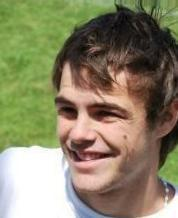

In [ ]:
import os
import random

images = os.listdir(target_dir)
random_image = random.choice(images)

# Получаем аннотацию
image_id = anno_dict.get(random_image, 'Аннотация не найдена')

print(f'Случайное изображение: {random_image}')
print(f'ID: {image_id}')

# Отобразим изображение
from IPython.display import Image, display
display(Image(os.path.join(target_dir, random_image)))

In [ ]:
from IPython.display import display, Image as IPImage

def show_images_by_class(target_class, images, target_dir, anno_dict):
    """
    Функция для отображения до 5 изображений заданного класса.
    Если изображений меньше 5, выводятся все доступные изображения.

    :param target_class: Класс, изображения которого нужно отобразить (строка или число).
    :param images: Список названий файлов изображений.
    :param target_dir: Директория, в которой находятся изображения.
    :param anno_dict: Словарь, сопоставляющий каждому изображению его класс.
    """
    # Фильтруем изображения по заданному классу
    class_images = [img for img in images if anno_dict.get(img) == str(target_class)]

    # Выбираем до 5 изображений
    selected_images = class_images[:5]

    # Если изображений меньше 5, выводим сообщение
    if len(class_images) < 5:
        print(f"Найдено {len(class_images)} изображений для класса {target_class}.")
    else:
        print(f"Выводим первые 5 изображений из {len(class_images)} доступных.")

    # Отображаем изображения
    for img_name in selected_images:
        img_path = os.path.join(target_dir, img_name)
        print(f"Отображаем изображение: {img_name}")
        display(IPImage(filename=img_path))

Выводим первые 5 изображений из 22 доступных.
Отображаем изображение: 028678.jpg


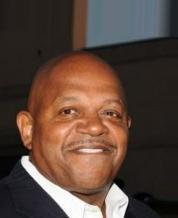

Отображаем изображение: 009742.jpg


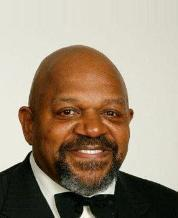

Отображаем изображение: 038435.jpg


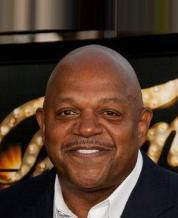

Отображаем изображение: 101852.jpg


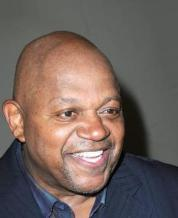

Отображаем изображение: 027696.jpg


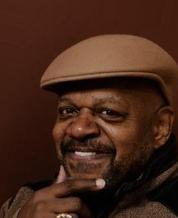

In [ ]:
show_images_by_class('222', images, target_dir, anno_dict)

# Классификация

In [ ]:
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from facenet_pytorch import MTCNN, InceptionResnetV1
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(image_size=160, margin=14, post_process=True, device=device)
facenet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [ ]:
import os

missing_files = []

for filename in anno_dict.keys():
    full_path = os.path.join(target_dir, filename)
    if not os.path.exists(full_path):
        missing_files.append(filename)

if missing_files:
    print(f"❌ Найдено {len(missing_files)} отсутствующих файлов:")
    print(missing_files[:10])  # Покажет первые 10
else:
    print("✅ Все изображения из anno_dict найдены в target_dir.")

❌ Найдено 2357 отсутствующих файлов:
['131731.jpg', '134007.jpg', '139106.jpg', '140935.jpg', '142601.jpg', '152380.jpg', '133005.jpg', '134209.jpg', '134272.jpg', '134680.jpg']


In [ ]:
filtered_anno_dict = {k: v for k, v in anno_dict.items()
                      if os.path.exists(os.path.join(target_dir, k))}
print(f"📦 Используем {len(filtered_anno_dict)} изображений из {len(anno_dict)} после фильтрации.")

📦 Используем 9654 изображений из 12011 после фильтрации.


In [ ]:
unique_values = len(set(filtered_anno_dict.values()))
print(unique_values)

500


In [ ]:
# === 1. Dataset с предобработкой изображений ===
class FaceDataset(Dataset):
    def __init__(self, image_dir, anno_dict, transform=None):
        self.image_dir = image_dir
        self.anno_dict = anno_dict
        self.images = list(anno_dict.keys())
        self.labels = list(map(int, [anno_dict[img] for img in self.images]))
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.images[idx])
        image = Image.open(image_path).convert('RGB')

        face = mtcnn(image)
        if face is None:
            face = torch.zeros((3, 160, 160))  # fallback

        if self.transform:
            face = self.transform(face)

        label = self.labels[idx]
        return face, label

In [ ]:
# === 2. Классификатор по эмбеддингам ===
class FaceClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.facenet = facenet  # только эмбеддинги
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        embeddings = self.facenet(x)
        return self.classifier(embeddings)

In [ ]:
# === 3. Обучение модели ===
def train_model(model, dataloader, criterion, optimizer):
    model.train()
    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
# === 4. Оценка качества ===
def evaluate_model(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return acc, f1

# Пробую разделить на train & test

In [ ]:
import random
from collections import defaultdict

def split_dict_by_class(anno_dict, train_ratio=0.8, seed=42):
    random.seed(seed)
    class_to_images = defaultdict(list)

    # Группируем изображения по меткам
    for img, label in anno_dict.items():
        class_to_images[label].append(img)

    train_dict, test_dict = {}, {}

    for label, images in class_to_images.items():
        if len(images) < 2:
            # Если слишком мало изображений — оставляем одно в train
            train_dict[images[0]] = label
            continue

        random.shuffle(images)
        split_idx = int(len(images) * train_ratio)
        train_images = images[:max(split_idx, 1)]  # хотя бы одно в train
        test_images = images[max(split_idx, 1):]

        for img in train_images:
            train_dict[img] = label
        for img in test_images:
            test_dict[img] = label

    return train_dict, test_dict

train_dict, test_dict = split_dict_by_class(filtered_anno_dict, train_ratio=0.8)
print(f"📊 Train: {len(train_dict)}, Test: {len(test_dict)}, Total classes: {len(set(train_dict.values()))}")


📊 Train: 7530, Test: 2124, Total classes: 500


In [ ]:
train_dataset = FaceDataset(target_dir, train_dict)
test_dataset = FaceDataset(target_dir, test_dict)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [ ]:
num_classes = len(set(filtered_anno_dict.values()))
model = FaceClassifier(num_classes).to(device)

# Замораживаем веса facenet внутри модели
for param in model.facenet.parameters():
    param.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=1e-3)

train_model(model, train_loader, criterion, optimizer)
acc, f1 = evaluate_model(model, test_loader)

100%|██████████| 471/471 [19:51<00:00,  2.53s/it]


In [ ]:
print(f"Accuracy: {acc:.4f}, F1: {f1:.4f}")

Accuracy: 0.8493, F1: 0.7754


# Дообучаем

In [ ]:
dataset = FaceDataset(target_dir, filtered_anno_dict)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

num_classes = len(set(filtered_anno_dict.values()))
model = FaceClassifier(num_classes).to(device)

# Замораживаем веса facenet внутри модели
for param in model.facenet.parameters():
    param.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=1e-3)

In [ ]:
# Обучение
train_model(model, dataloader, criterion, optimizer)

100%|██████████| 604/604 [24:12<00:00,  2.40s/it]


In [ ]:
acc, f1 = evaluate_model(model, dataloader)
print(f"Accuracy: {acc:.4f}, F1: {f1:.4f}")

Accuracy: 0.8960, F1: 0.8352


In [ ]:
def predict_single_image(image_path, model, transform=None):
    model.eval()

    # Загрузка и преобразование изображения
    image = Image.open(image_path).convert('RGB')
    face = mtcnn(image)

    if face is None:
        print("❗ Лицо не найдено на изображении.")
        return None

    if transform:
        face = transform(face)

    face = face.unsqueeze(0).to(device)  # Добавляем batch dimension

    # Предсказание
    with torch.no_grad():
        output = model(face)
        predicted_class = torch.argmax(output, dim=1).item()

    return predicted_class

In [ ]:
image_path = os.path.join(target_dir, '075422.jpg')  # или другой файл
predicted_class = predict_single_image(image_path, model)
print(f"📸 Предсказанный класс: {predicted_class}")

📸 Предсказанный класс: 222


# FGSM

In [ ]:
# model: атакуемый классификатор
# x: чистое изображение
# target -- целевой класс или исходный класс
# eps: сила атаки
# targeted: режим атаки

# атака возможна в двух режимах (targeted и untargeted)
# в случае targeted -- параметр target -- целевой класс
# в случае untargeted -- параметр target -- исходный класс


def fgsm(model, x, target, eps=0.25, targeted=True):
    # копируем входной тензор
    input_ = x.clone().detach_()
    # включаем градиенты
    input_.requires_grad_()

    logits = model(input_)
    target = torch.LongTensor([target])
    model.zero_grad()
    # считаем лосс функцию
    loss = nn.CrossEntropyLoss()(logits, target)
    # производим обратное распространение ошибки
    loss.backward()

    if targeted:
        # если атака направленная -- приближаем к таргету
        out = input_ - eps * input_.grad.sign()
    else:
       # если атака ненаправленная -- отдаляем от оригинала
        out = input_ + eps * input_.grad.sign()
    # обрезаем в стандартный диапазон значений пикселей изображения
    out.clamp_(min=-1.0, max=1.0)
    return out

In [ ]:
# Выбираем случайный индекс
idx = random.randint(0, len(dataset) - 1)

# Получаем изображение и метку
image, label = dataset[idx]

# Подготавливаем для модели
image = image.unsqueeze(0).to(device)  # добавляем batch dimension
label = torch.tensor(label).to(device)  # переносим на нужное устройство

In [ ]:
model.eval()
# Атака
adv_image = fgsm(model, image, target=label.item(), eps=0.05, targeted=False)

In [ ]:
model.eval()

# Предсказание до атаки
with torch.no_grad():
    orig_pred = model(image)
    orig_class = torch.argmax(orig_pred, dim=1).item()

# Предсказание после атаки
with torch.no_grad():
    adv_pred = model(adv_image)
    adv_class = torch.argmax(adv_pred, dim=1).item()

print(f"🎯 Оригинальный класс: {orig_class}")
print(f"🎯 Предсказанный класс после атаки: {adv_class}")

🎯 Оригинальный класс: 225
🎯 Предсказанный класс после атаки: 498


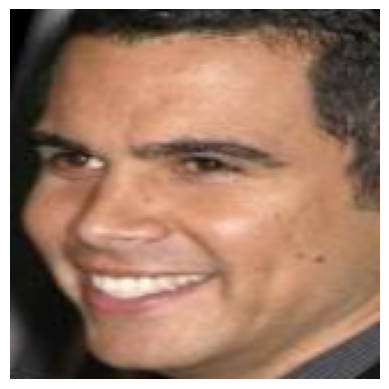

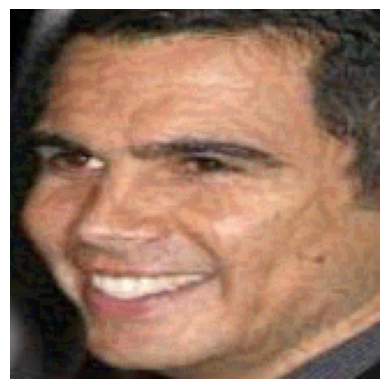

In [ ]:
import matplotlib.pyplot as plt

def show_tensor_image(tensor):
    tensor = tensor.squeeze(0).detach().cpu()
    tensor = tensor - tensor.min()  # поднимаем минимум к 0
    tensor = tensor / (tensor.max() + 1e-8)  # нормируем максимум к 1, защита от деления на 0
    np_image = tensor.permute(1, 2, 0).numpy()
    plt.imshow(np_image)
    plt.axis('off')
    plt.show()

# Оригинальное изображение
show_tensor_image(image)

# Атакованное изображение
show_tensor_image(adv_image)

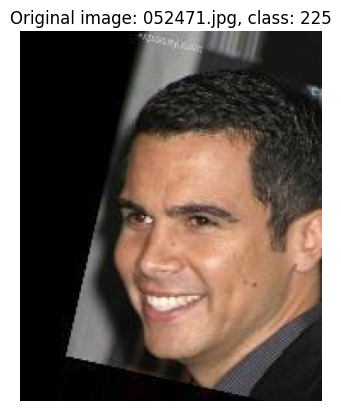

In [ ]:
# Изначальная фотография
from PIL import Image as PILImage

image, true_label = dataset[idx]
image = image.unsqueeze(0).to(device)
true_label = torch.tensor([true_label]).to(device)

# Получаем имя файла по индексу
image_filename = dataset.images[idx]
image_path = os.path.join(target_dir, image_filename)

# Загружаем оригинал
original_img = PILImage.open(image_path).convert('RGB')

# Показываем
plt.imshow(original_img)
plt.title(f"Original image: {image_filename}, class: {true_label.item()}")
plt.axis('off')
plt.show()

Выводим первые 5 изображений из 14 доступных.
Отображаем изображение: 047003.jpg


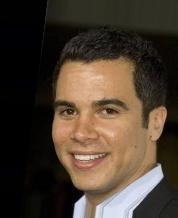

Отображаем изображение: 045519.jpg


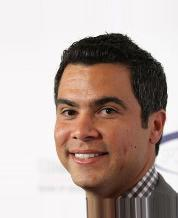

Отображаем изображение: 005585.jpg


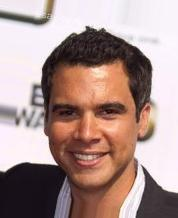

Отображаем изображение: 036368.jpg


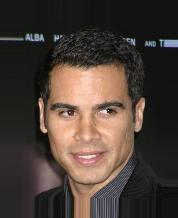

Отображаем изображение: 000230.jpg


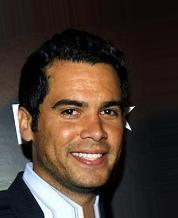

In [ ]:
show_images_by_class('225', images, target_dir, anno_dict)

# PGD

In [ ]:
# x: чистое изображение
# label: метка чистого изображения
# k: кол-во шагов атаки
# eps: ограничение на добавку
# eps_step: ограничение на добавку в процессе каждого шага

# На каждом шаге происходит FGSM атака с последующим проецированием на l-inf шар вокруг x с ограничением eps

def pgd(model, x, target, targeted, k=10, eps=0.15, eps_step=0.015):
    x_min = x - eps
    x_max = x + eps

    # инициализируем x_adv случайным возмущением
    x_adv = x + eps * (2 * torch.rand_like(x) - 1)
    # обрезаем в стандартный диапазон значений пикселей изображения
    x_adv.clamp_(min=0.0, max=1.0)

    for i in range(k):
        # шаг FGSM
        x_adv = fgsm(model, x_adv, target, eps_step, targeted)
        # шаг проекции
        x_adv = torch.min(x_max, torch.max(x_min, x_adv))

    # обрезаем в стандартный диапазон значений пикселей изображения
    x_adv.clamp_(min=-1.0, max=1.0)
    return x_adv

In [ ]:
adv_image = pgd(model, image, target=label.item(), targeted=False)

In [ ]:
# Предсказание до атаки
with torch.no_grad():
    orig_pred = model(image)
    orig_class = torch.argmax(orig_pred, dim=1).item()

# Предсказание после атаки
with torch.no_grad():
    adv_pred = model(adv_image)
    adv_class = torch.argmax(adv_pred, dim=1).item()

print(f"🎯 Оригинальный класс: {orig_class}")
print(f"🎯 Предсказанный класс после атаки: {adv_class}")

🎯 Оригинальный класс: 339
🎯 Предсказанный класс после атаки: 312


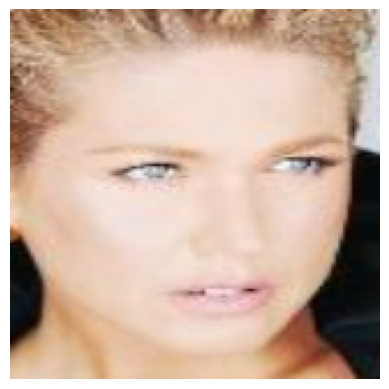

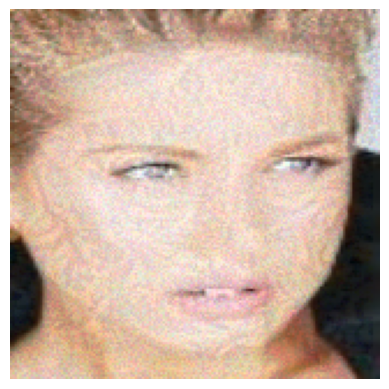

In [ ]:
def show_tensor_image(tensor):
    tensor = tensor.squeeze(0).detach().cpu()
    tensor = tensor - tensor.min()  # поднимаем минимум к 0
    tensor = tensor / (tensor.max() + 1e-8)  # нормируем максимум к 1, защита от деления на 0
    np_image = tensor.permute(1, 2, 0).numpy()
    plt.imshow(np_image)
    plt.axis('off')
    plt.show()

# Оригинальное изображение
show_tensor_image(image)

# Атакованное изображение
show_tensor_image(adv_image)

# C&W

In [ ]:
import numpy as np

In [ ]:
# значения по умолчанию
# MAX_ITERATIONS = 10  -- максимальное кол-во итераций градиентного спуска
# LEARNING_RATE = 1e-2 -- чем больше тем быстрее, но результат менее точный
# INITIAL_CONST = 1e-3 -- начальное значение константы C
# LARGEST_CONST = 20   -- максимальное значение константы C
# CONST_FACTOR = 2.0   -- CONST_FACTOR > 1, скорость с которой увеличивается константа C
# norm = 'L2'          -- норма для второй компоненты лосс функции ('L2', 'L0', 'Linf')
# threshold = 0.0001   -- порог для определения успешности атаки

def cw_attack(model, img, target, targeted, INITIAL_CONST = 1e-3, batch_size=1, num_channels=3,
              image_size=160, LEARNING_RATE = 1e-2, LARGEST_CONST = 20, MAX_ITERATIONS = 10, norm='L2',
              const_factor = 2.0, threshold = .0001):
  shape = (batch_size, num_channels, image_size, image_size)

  # оптимизируемая добавка
  modifier = torch.autograd.Variable(torch.zeros(shape, dtype=torch.float32, device=device), requires_grad=True)

  simg = img.to(device)
  lab = np.argmax(model(img).detach().numpy())
  lab = torch.tensor(lab)
  slab = lab.to(device)
  tlab = torch.tensor(target).to(device)
  const = []

  # one hot закодированные метрки классов
  slab = torch.nn.functional.one_hot(slab, num_classes= 500)
  if not tlab is None:
    tlab = torch.nn.functional.one_hot(tlab, num_classes= 500)

  optimizer = torch.optim.Adam([modifier], lr=LEARNING_RATE)

  CONST = INITIAL_CONST

  while CONST < LARGEST_CONST:
      for step in range(MAX_ITERATIONS):
          newimg = modifier + simg
          newimg.clamp_(min=-1.0, max=1.0)
          output = model(newimg)

          real = torch.sum((slab)*output,-1) # по сути это значение вектора выхода в ячейке исходного класса


          if targeted:
              # приближаем к целевому классу
              other = torch.sum((tlab)*output,-1) # значение вектора выхода в ячейке целевого класса
          else:
              # приближаем к ближайшему классу, отличному от изначального
              other = torch.max((1-slab)*output - (slab*10000)) # значение вектора выхода в ячейке ближайшего неисходного класса

          # первая компонента лосса
          loss1 = torch.maximum(torch.tensor(0.0, device=device), real-other+0.1)

          # вторая компонента лосса -- ограничение добавки по норме
          if norm == 'L0':
            loss2 = torch.sum(torch.abs(modifier) > 0)
          if norm == 'L2':
            loss2 = torch.sum(torch.square(modifier))
          if norm == 'Linf':
            loss2 = torch.max(torch.abs(modifier))

          # суммарный лосс
          loss = CONST*loss1+loss2

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          if loss1.item() < threshold:
              return newimg

      # атака еще не успешна, пробуем с другой константой
      CONST *= const_factor

In [ ]:
x_adv =  cw_attack(model, image.clone(), label.item(), targeted=False, norm='Linf')

In [ ]:
# Предсказание до атаки
with torch.no_grad():
    orig_pred = model(image)
    orig_class = torch.argmax(orig_pred, dim=1).item()

# Предсказание после атаки
with torch.no_grad():
    adv_pred = model(x_adv)
    adv_class = torch.argmax(adv_pred, dim=1).item()

print(f"🎯 Оригинальный класс: {orig_class}")
print(f"🎯 Предсказанный класс после атаки: {adv_class}")

🎯 Оригинальный класс: 225
🎯 Предсказанный класс после атаки: 7


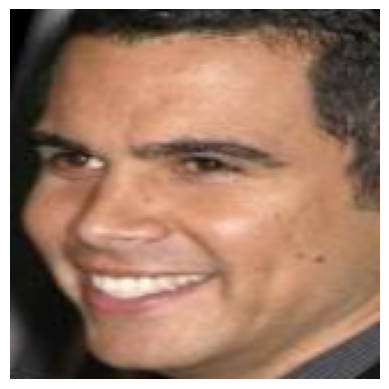

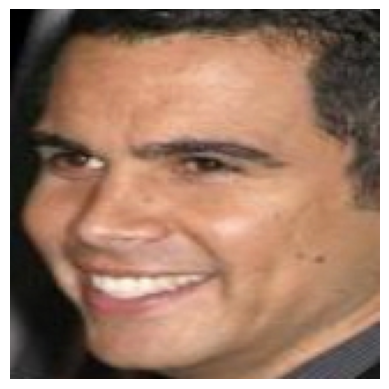

In [ ]:
def show_tensor_image(tensor):
    tensor = tensor.squeeze(0).detach().cpu()
    tensor = tensor - tensor.min()  # поднимаем минимум к 0
    tensor = tensor / (tensor.max() + 1e-8)  # нормируем максимум к 1, защита от деления на 0
    np_image = tensor.permute(1, 2, 0).numpy()
    plt.imshow(np_image)
    plt.axis('off')
    plt.show()

# Оригинальное изображение
show_tensor_image(image)

# Атакованное изображение
show_tensor_image(x_adv)

# C&W targeted

In [ ]:
# Исходное изображение и его класс
original_image = image.clone()
original_label = label.item()  # текущий класс изображения

# Выбираем целевой класс для атаки (например, класс 123)
target_class = 123

# Запускаем направленную атаку
x_adv_targeted = cw_attack(
    model=model,
    img=original_image,
    target=target_class,       # целевой класс
    targeted=True,             # активируем режим направленной атаки
    norm='Linf',               # норма для ограничения
    MAX_ITERATIONS=20,         # можно увеличить число итераций
    LEARNING_RATE=0.01         # или настроить другие параметры
)

In [ ]:
# Предсказание для adversarial-изображения
adv_pred = model(x_adv_targeted).argmax().item()

if adv_pred == target_class:
    print("Атака успешна: модель классифицировала изображение как целевой класс!")
else:
    print("Атака не удалась. Попробуйте увеличить MAX_ITERATIONS или CONST_FACTOR.")

Атака успешна: модель классифицировала изображение как целевой класс!


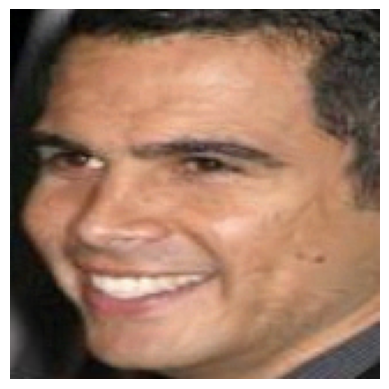

In [ ]:
# Атакованное изображение
show_tensor_image(x_adv_targeted)

# DeepFool

In [ ]:
from torch.autograd import Variable
import torch as torch
import copy


def deepfool(net, image, target=None, targeted=False, num_classes=500, max_iter=50):
    device = 'cpu'
    image = image.float().to(device)
    f_image = net(image).data.cpu().numpy().flatten()
    # сортируем выходы модели по убыванию
    I = (np.array(f_image)).flatten().argsort()[::-1]
    I = I[0:num_classes]
    # определяем исходную метку класса
    label = I[0]


    input_shape = image.cpu().numpy().shape
    pert_image = copy.deepcopy(image)
    w = np.zeros(input_shape)
    # переменная для аггрегирования атакующей добавки
    r_tot = np.zeros(input_shape)

    loop_i = 0

    pert_image = pert_image.reshape(3, 160, 160)
    # будем считать градиенты относительно изображения, которое в процессе станет атакованным
    x = Variable(pert_image[None, :], requires_grad=True)
    fs = net(x)
    fs_list = [fs[0,I[k]] for k in range(num_classes)]
    k_i = label

    # выполняем до тех пор пока текущая метка класса совпадает с исходной (или до макс. кол-ва итераций)
    while k_i == label and loop_i < max_iter:
        li = np.inf
        fs = net(x)
        fs[0, I[0]].backward(retain_graph=True)
        grad_orig = x.grad.data.cpu().numpy().copy() # градиент относительно исходной метки класса

        # итерация по всем классам
        for k in range(1, num_classes):
            x.grad.zero_()
            fs = net(x)
            fs[0, I[k]].backward()
            cur_grad = x.grad.data.cpu().numpy().copy() # градиент относительно k-й метки класса

            # вычисляем текущие wk и fk
            w_k = cur_grad - grad_orig          # wk
            f_k = (fs[0, I[k]] - fs[0, I[0]]).data.cpu().numpy()  # fk

            li_k = abs(f_k)/np.linalg.norm(w_k.flatten())

            # выбираем минимальный li
            if li_k < li:
                li = li_k
                w = w_k

        # вычисляем добавку на текущем шаге
        r_i =  (li) * w / np.linalg.norm(w)
        # добавляем ее к общей добавке
        r_tot = np.float32(r_tot + r_i)

        # обновляем атакованное изображение
        pert_image = image + torch.from_numpy(r_tot).to(device)

        x = Variable(pert_image, requires_grad=True)
        fs = net(x)
        # вычисляем новую метку класса
        k_i = np.argmax(fs.data.cpu().numpy().flatten())

        loop_i += 1

    return pert_image

In [ ]:
x_adv = deepfool(model, image.clone())

In [ ]:
# Предсказание до атаки
with torch.no_grad():
    orig_pred = model(image)
    orig_class = torch.argmax(orig_pred, dim=1).item()

# Предсказание после атаки
with torch.no_grad():
    adv_pred = model(x_adv)
    adv_class = torch.argmax(adv_pred, dim=1).item()

print(f"🎯 Оригинальный класс: {orig_class}")
print(f"🎯 Предсказанный класс после атаки: {adv_class}")

🎯 Оригинальный класс: 225
🎯 Предсказанный класс после атаки: 7


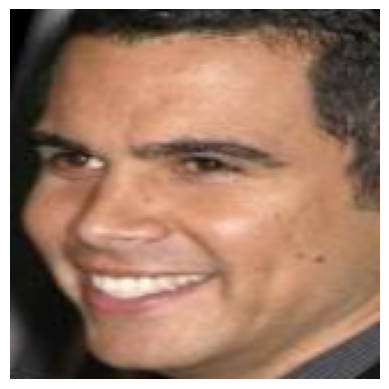

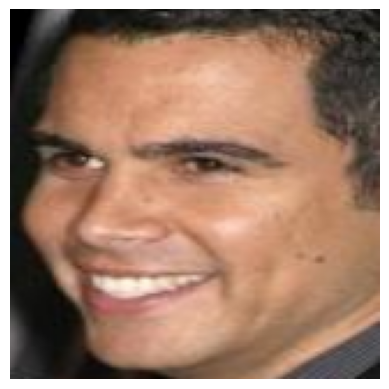

In [ ]:
def show_tensor_image(tensor):
    tensor = tensor.squeeze(0).detach().cpu()
    tensor = tensor - tensor.min()  # поднимаем минимум к 0
    tensor = tensor / (tensor.max() + 1e-8)  # нормируем максимум к 1, защита от деления на 0
    np_image = tensor.permute(1, 2, 0).numpy()
    plt.imshow(np_image)
    plt.axis('off')
    plt.show()

# Оригинальное изображение
show_tensor_image(image)

# Атакованное изображение
show_tensor_image(x_adv)

# JSMA

In [ ]:
print(image.min(), image.max())

tensor(-0.9961) tensor(0.9961)


In [ ]:
def compute_jacobian(model, image):
    '''
    :param model: the model to compute the Jacobian matrix
    :param image: the input image, 1*784
    :return: the Jacobian matrix, 10*784
    '''
    image_tmp = image.clone().detach().requires_grad_(True)
    output = model(image_tmp.reshape(1, 3, 160, 160))

    num_features = int(np.prod(image_tmp.shape[1:]))
    jacobian = torch.zeros([output.size()[1], num_features])

    for i in range(output.size()[1]):
        if image_tmp.grad is not None:
            image_tmp.grad.zero_()
        output[0][i].backward(retain_graph=True)
        jacobian[i] = image_tmp.grad.clone()

    return jacobian



def saliency_map(jacobian, target_index, increasing, search_space, nb_features):
    '''
    :param jacobian: the Jacobian matrix of forward derivative, 10*784
    :param target_index: the target class, 0-9
    :param increasing: whether to increase the prediction score, True or False
    :param search_space: the search domain, 1*784
    :param nb_features: the number of features, 784
    :return: the most significant two pixels, p and q
    '''

    domain = torch.eq(search_space, 1).float()
    all_sum = torch.sum(jacobian, dim=0, keepdim=True)
    target_grad = jacobian[target_index]
    others_grad = all_sum - target_grad

    if increasing:
        increase_coef = 2 * (torch.eq(domain, 0)).float()
    else:
        increase_coef = -1 * 2 * (torch.eq(domain, 0)).float()

    target_tmp = target_grad.clone()
    target_tmp -= increase_coef * torch.max(torch.abs(target_grad))

    alpha = target_tmp.view(-1, 1, nb_features) + target_tmp.view(-1, nb_features, 1)

    others_tmp = others_grad.clone()
    others_tmp += increase_coef * torch.max(torch.abs(others_grad))
    beta = others_tmp.view(-1, 1, nb_features) + others_tmp.view(-1, nb_features, 1)

    tmp = np.ones((nb_features, nb_features), int)
    np.fill_diagonal(tmp, 0)
    zero_diagonal = torch.from_numpy(tmp).byte()

    if increasing:
        mask1 = torch.gt(alpha, 0.0)
        mask2 = torch.lt(beta, 0.0)
    else:
        mask1 = torch.lt(alpha, 0.0)
        mask2 = torch.gt(beta, 0.0)

    mask = torch.mul(torch.mul(mask1, mask2), zero_diagonal.view_as(mask1))
    saliency_map = torch.mul(torch.mul(alpha, torch.abs(beta)), mask.float())
    max_value, max_idx = torch.max(saliency_map.view(-1, nb_features * nb_features), dim=1)
    p = max_idx // nb_features
    q = max_idx % nb_features
    return p, q


def jsma(model, image, target, targeted=True, theta=0.5, gamma=0.1):
    '''
    :param image: the input image, 1*784, numpy array
    :param ys_target: the target class, 0-9, int
    :param theta: the perturbation value
    :param gamma: the ratio of the number of features to be perturbed
    :param model: the model to be attacked
    :return: the adversarial sample
    '''
    image = image.flatten()[None, :]
    image_tmp = np.copy(image)
    var_sample = Variable(torch.from_numpy(image_tmp), requires_grad=True)
    var_target = Variable(torch.LongTensor([target]))

    if theta > 0:
        increasing = True
    else:
        increasing = False

    num_features = int(np.prod(image_tmp.shape[1:]))
    shape = var_sample.size()

    # на каждой итерации меняем 2 пикселя, поэтому делим максимальное кол-во итераций на 2
    max_iters = int(np.ceil(num_features * gamma / 2.0))

    # маскируем пространство поиска (не меняем пиксели, значения которых уже граничные)
    if increasing:
        search_domain = torch.lt(var_sample, 0.99)
    else:
        search_domain = torch.gt(var_sample, -0.99)
    search_domain = search_domain.view(num_features)

    model.eval()
    output = model(var_sample.reshape(1, 3, 160, 160))
    current = torch.max(output.data, 1)[1].cpu().numpy()

    iter = 0
    while (iter < max_iters) and (current[0] != target) and (search_domain.sum() != 0):
        jacobian = compute_jacobian(model, var_sample)
        # определяем 2 самых значительных пикселя
        p1, p2 = saliency_map(jacobian, target, increasing, search_domain, num_features)
        # применяем модификации к этим пикселям
        var_sample_flatten = var_sample.view(-1, num_features).clone().detach_()
        var_sample_flatten[0, p1] += theta
        var_sample_flatten[0, p2] += theta

        new_sample = torch.clamp(var_sample_flatten, min=-1.0, max=1.0)
        new_sample = new_sample.view(shape)
        # зануляем пространство поиска для использованных пикселей
        search_domain[p1] = 0
        search_domain[p2] = 0
        var_sample = Variable(new_sample, requires_grad=True)

        output = model(var_sample.reshape(1, 3, 160, 160))
        # определяем текущий класс
        current = torch.max(output.data, 1)[1].cpu().numpy()
        iter += 1

    adv_samples = var_sample
    return adv_samples.reshape(1, 3, 160, 160)

In [ ]:
image.shape

torch.Size([1, 3, 160, 160])

In [ ]:
x_adv = jsma(model, image.clone(), 112)

RuntimeError: shape '[1, 1, 160, 160]' is invalid for input of size 76800

# Black box

In [ ]:
import torch
import torchvision.transforms as T
from torchvision import datasets, models
from torch.nn import functional as F
import torch.nn as nn
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.optim import Adam
import itertools
import math
import heapq
from torch.nn.modules import Upsample

In [ ]:
mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=mean.ravel(), std=std.ravel())
])

In [ ]:
def preprocess_image(img_path):
    transform = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=mean.ravel(), std=std.ravel()),
    ])
    img = Image.open(img_path).convert('RGB')
    img = transform(img).unsqueeze(0)
    return img

def tensor_to_numpy(x):
    x = x.squeeze().permute(1, 2, 0).detach().cpu().numpy()
    return x

def normalize(perturbed):
	return (perturbed - mean.to(device))/std.to(device)

def denormalize(perturbed):
     return perturbed*std.to(device) + mean.to(device)

def show_attack(original, adv, model_to_prob):
    with torch.no_grad():
        clean_probs = model_to_prob(original).detach().cpu().numpy()
        attacked_probs = model_to_prob(adv).detach().cpu().numpy()
    original_normed = denormalize(original)
    adv_normed = denormalize(adv)
    original_normed = original_normed.cpu()
    adv_normed = adv_normed.cpu()
    difference = original_normed - adv_normed
    if difference.abs().max() > 0:
        difference = (difference - difference.min())/(difference.max() - difference.min())
    f, axarr = plt.subplots(1, 3, figsize=(10, 8))
    axarr[0].imshow(tensor_to_numpy(original_normed))
    axarr[0].set_title("Original, class: " + str(clean_probs.argmax()))
    axarr[0].axis('off')
    axarr[1].imshow(tensor_to_numpy(difference))
    axarr[1].set_title("Difference")
    axarr[1].axis('off')
    axarr[2].imshow(tensor_to_numpy(adv_normed))
    axarr[2].set_title("Attacked, class: " + str(attacked_probs.argmax()))
    axarr[2].axis('off')
    plt.show()

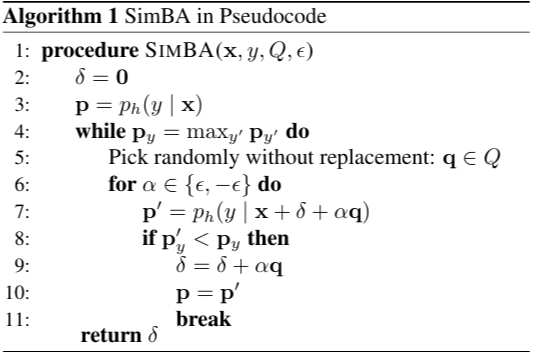

In [ ]:
def simba(x, y, model, epsilon=0.1, num_iters=10000, targeted=False):
    x = denormalize(x)
    n_dims = x.view(1, -1).size(1)
    perm = torch.randperm(n_dims)
    probs = F.softmax(model(normalize(x)), dim=-1).data[:, y]
    last_prob = torch.diag(probs)

    for i in tqdm(range(num_iters)):
        delta = torch.zeros(n_dims).to(device)
        delta[perm[i]] = epsilon

        left_vec = (x - delta.view(x.size())).clamp(-1, 1)
        probs = F.softmax(model(normalize(left_vec))).data[:, y]
        left_prob = torch.diag(probs)

        if targeted != (left_prob < last_prob).item():
            x = left_vec.clone()
            last_prob = left_prob
        else:
            right_vec = (x + delta.view(x.size())).clamp(-1, 1)
            probs = F.softmax(model(normalize(right_vec))).data[:, y]
            right_prob = torch.diag(probs)

            if targeted != (right_prob < last_prob).item():
                x = right_vec.clone()
                last_prob = right_prob
    return normalize(x)

  0%|          | 0/10000 [00:00<?, ?it/s]<ipython-input-38-030010ac5261>:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(model(normalize(left_vec))).data[:, y]
<ipython-input-38-030010ac5261>:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(model(normalize(right_vec))).data[:, y]
100%|██████████| 10000/10000 [42:19<00:00,  3.94it/s]


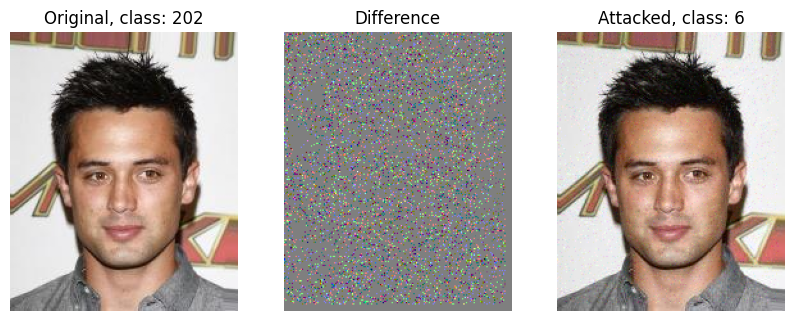

In [ ]:
image_path = '/content/images_dataset/000007.jpg'
data = preprocess_image(image_path).to(device)
original_class = model(data).argmax().item()
with torch.no_grad():
    adversarial_data = simba(data, original_class, model)
show_attack(data, adversarial_data, model)